# Evolution Strategies Method

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle

In [2]:
import gym
from evostra import EvolutionStrategy

In [3]:
from model import Model

## Set Configs

In [4]:
POPULATION_SIZE = 20
EPISODE_AVERAGE = 1
MAX_TIME = 1500
SIGMA = 0.1
LR = 0.1
DECAY_RATE = 0.995
INITIAL_EXPLORATION = 1.0
FINAL_EXPLORATION = 0.0
EXPLORATION_DEC_STEPS = 1e6
PRINT_EVERY = 1

## Set Environment

In [5]:
ENV_NAME = 'BipedalWalker-v2'
env = gym.make(ENV_NAME); env.seed(90); # remove unwrapped

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
# env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(24,)
Action space Box(4,)


## Define [ES](https://arxiv.org/pdf/1703.03864.pdf) Agent

In [7]:
class ESAgent():
    
    def __init__(self, env, population_size=20, episode_average=1, max_time=1500, 
                 sigma=0.1, learning_rate=0.1, decay_rate=0.995, 
                 initial_exploration=1.0, final_exploration=0.0, exploration_dec_steps=1e6):
    
        self.env = env
                
        self.population_size = population_size
        self.episode_average = episode_average
        self.max_time = max_time
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.initial_exploration = initial_exploration
        self.final_exploration = final_exploration
        self.exploration_dec_steps = exploration_dec_steps
        self.agent_history_length = 1
        
        self.exploration = self.initial_exploration
        
        self.model = Model()
        self.es = EvolutionStrategy(self.model.get_weights(), self.get_reward, 
                                    self.population_size, self.sigma, self.learning_rate, self.decay_rate, num_threads=1)
        
        self.scores = []
        
    def get_predicted_action(self, sequence):
        
        action = self.model.predict(np.array(sequence))
        return action
    
    def get_reward(self, weights):
        
        total_reward = 0.0
        self.model.set_weights(weights)
        
        for i_episode in range(1, self.episode_average+1):
            
            state = self.env.reset()
            sequence = [state] * self.agent_history_length
            done = False
            
            while not done:
                
                self.exploration = max(self.final_exploration, self.exploration - self.initial_exploration / self.exploration_dec_steps)
                if random.random() < self.exploration:
                    action = self.env.action_space.sample()
                else:
                    action = self.get_predicted_action(sequence)
                
                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward
                sequence = sequence[1:]
                sequence.append(next_state)
            
        average_reward = total_reward/ self.episode_average
        self.scores.append(average_reward)
        
        return average_reward
    
    def train(self, num_episodes, print_every=10):
        self.es.run(num_episodes, print_step=print_every)
        self.save(f'../agents/ES_{ENV_NAME}.pth')
        
        return self.scores
    
    def save(self, policy_path):
        
        if not os.path.exists('../agents/'): os.makedirs('../agents/')
        with open(policy_path, 'wb') as weights:
            pickle.dump(self.es.get_weights(), weights)
            
    def load(self, policy_path):
        
        with open(policy_path, 'rb') as weights:
            self.model.set_weights(pickle.load(weights))
        self.es.weights = self.model.get_weights()
        
    def watch(self, num_episodes=10, render=True):
        
        self.model.set_weights(self.es.weights)
        for i_episode in range(1, num_episodes+1):
            
            total_reward = 0.0
            state = self.env.reset()
            sequence = [state] * self.agent_history_length
            done = False
            
            while not done:
                if render:
                    self.env.render()
                action = self.get_predicted_action(sequence)
                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward
                sequence = sequence[1:]
                sequence.append(next_state)
                
            print(f'Episode: {i_episode}, Total Reward: {total_reward:.2f}')

In [8]:
agent = ESAgent(env, POPULATION_SIZE, EPISODE_AVERAGE, MAX_TIME, SIGMA, LR, DECAY_RATE, 
                INITIAL_EXPLORATION, FINAL_EXPLORATION, EXPLORATION_DEC_STEPS)

## Train The Agent

In [9]:
scores = agent.train(num_episodes=1000, print_every=PRINT_EVERY)

Episode: 1, Average Reward: -118.74
Episode: 2, Average Reward: -73.00
Episode: 3, Average Reward: -109.01
Episode: 4, Average Reward: -103.03
Episode: 5, Average Reward: -99.42
Episode: 6, Average Reward: -88.58
Episode: 7, Average Reward: -124.86
Episode: 8, Average Reward: -118.71
Episode: 9, Average Reward: -96.63
Episode: 10, Average Reward: -88.53
Episode: 11, Average Reward: -105.72
Episode: 12, Average Reward: -106.54
Episode: 13, Average Reward: -110.71
Episode: 14, Average Reward: -105.52
Episode: 15, Average Reward: -111.57
Episode: 16, Average Reward: -108.74
Episode: 17, Average Reward: -115.19
Episode: 18, Average Reward: -105.82
Episode: 19, Average Reward: -223.40
Episode: 20, Average Reward: -114.24
Episode: 21, Average Reward: -118.60
Episode: 22, Average Reward: -104.23
Episode: 23, Average Reward: -91.33
Episode: 24, Average Reward: -106.31
Episode: 25, Average Reward: -118.69
Episode: 26, Average Reward: -117.17
Episode: 27, Average Reward: -107.49
Episode: 28, Ave

Episode: 222, Average Reward: -101.11
Episode: 223, Average Reward: -96.12
Episode: 224, Average Reward: -39.77
Episode: 225, Average Reward: -99.54
Episode: 226, Average Reward: -93.04
Episode: 227, Average Reward: -92.81
Episode: 228, Average Reward: -97.71
Episode: 229, Average Reward: -93.55
Episode: 230, Average Reward: -118.02
Episode: 231, Average Reward: -86.00
Episode: 232, Average Reward: -93.62
Episode: 233, Average Reward: -90.42
Episode: 234, Average Reward: -88.00
Episode: 235, Average Reward: -88.33
Episode: 236, Average Reward: -72.32
Episode: 237, Average Reward: -78.77
Episode: 238, Average Reward: -93.98
Episode: 239, Average Reward: -99.83
Episode: 240, Average Reward: -84.81
Episode: 241, Average Reward: -88.18
Episode: 242, Average Reward: -96.36
Episode: 243, Average Reward: -78.46
Episode: 244, Average Reward: -70.05
Episode: 245, Average Reward: -75.04
Episode: 246, Average Reward: -93.52
Episode: 247, Average Reward: -98.27
Episode: 248, Average Reward: -71.28

Episode: 444, Average Reward: -88.03
Episode: 445, Average Reward: -155.26
Episode: 446, Average Reward: -99.54
Episode: 447, Average Reward: 26.77
Episode: 448, Average Reward: -88.07
Episode: 449, Average Reward: -78.54
Episode: 450, Average Reward: 2.25
Episode: 451, Average Reward: -66.69
Episode: 452, Average Reward: 28.65
Episode: 453, Average Reward: -72.93
Episode: 454, Average Reward: -46.26
Episode: 455, Average Reward: -43.43
Episode: 456, Average Reward: 20.92
Episode: 457, Average Reward: -89.21
Episode: 458, Average Reward: -72.66
Episode: 459, Average Reward: -54.46
Episode: 460, Average Reward: -72.87
Episode: 461, Average Reward: -56.75
Episode: 462, Average Reward: -101.04
Episode: 463, Average Reward: -51.69
Episode: 464, Average Reward: -92.47
Episode: 465, Average Reward: -24.79
Episode: 466, Average Reward: -9.64
Episode: 467, Average Reward: -56.27
Episode: 468, Average Reward: -74.85
Episode: 469, Average Reward: -48.14
Episode: 470, Average Reward: -87.58
Episo

Episode: 667, Average Reward: -66.76
Episode: 668, Average Reward: -34.12
Episode: 669, Average Reward: -87.04
Episode: 670, Average Reward: -86.44
Episode: 671, Average Reward: -91.36
Episode: 672, Average Reward: -42.20
Episode: 673, Average Reward: -89.33
Episode: 674, Average Reward: 49.48
Episode: 675, Average Reward: -76.25
Episode: 676, Average Reward: -60.39
Episode: 677, Average Reward: 34.79
Episode: 678, Average Reward: -71.42
Episode: 679, Average Reward: -76.75
Episode: 680, Average Reward: -85.74
Episode: 681, Average Reward: -96.64
Episode: 682, Average Reward: -89.06
Episode: 683, Average Reward: -65.76
Episode: 684, Average Reward: -84.68
Episode: 685, Average Reward: -81.58
Episode: 686, Average Reward: -61.45
Episode: 687, Average Reward: 20.56
Episode: 688, Average Reward: -92.49
Episode: 689, Average Reward: -85.56
Episode: 690, Average Reward: 49.36
Episode: 691, Average Reward: -74.23
Episode: 692, Average Reward: -92.22
Episode: 693, Average Reward: 25.30
Episod

Episode: 891, Average Reward: -51.03
Episode: 892, Average Reward: -3.87
Episode: 893, Average Reward: -9.33
Episode: 894, Average Reward: -109.18
Episode: 895, Average Reward: 39.56
Episode: 896, Average Reward: -72.18
Episode: 897, Average Reward: -83.38
Episode: 898, Average Reward: 45.16
Episode: 899, Average Reward: 14.95
Episode: 900, Average Reward: -141.94
Episode: 901, Average Reward: -82.93
Episode: 902, Average Reward: 2.82
Episode: 903, Average Reward: -78.93
Episode: 904, Average Reward: 24.50
Episode: 905, Average Reward: -58.59
Episode: 906, Average Reward: -66.21
Episode: 907, Average Reward: 8.82
Episode: 908, Average Reward: -52.55
Episode: 909, Average Reward: -71.90
Episode: 910, Average Reward: -85.43
Episode: 911, Average Reward: 27.93
Episode: 912, Average Reward: -13.27
Episode: 913, Average Reward: -30.42
Episode: 914, Average Reward: -75.08
Episode: 915, Average Reward: -73.35
Episode: 916, Average Reward: -67.70
Episode: 917, Average Reward: -80.51
Episode: 9

## Evaluate The Agent

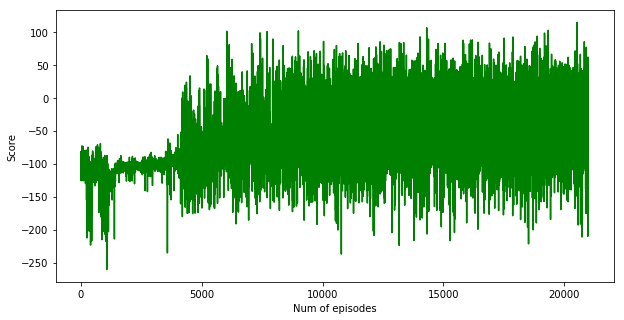

In [10]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('../images/'): os.makedirs('../images/')
plt.savefig('../images/plot_of_evolution_strategies_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [11]:
agent.load(f'../agents/ES_{ENV_NAME}.pth');

In [12]:
agent.watch(num_episodes=10)

Episode: 1, Total Reward: 18.78
Episode: 2, Total Reward: -51.97
Episode: 3, Total Reward: -86.35
Episode: 4, Total Reward: -102.73
Episode: 5, Total Reward: 48.10
Episode: 6, Total Reward: -0.49
Episode: 7, Total Reward: -23.76
Episode: 8, Total Reward: -86.71
Episode: 9, Total Reward: -85.40
Episode: 10, Total Reward: 12.36


---